# Tutorial 2 - Countermeasures

This tutorial covers:
    
- Generating pseudorandomness in circuits (`wbkit`), existing and custom
- Applying countermeasures (masking, shuffling) to circuits (`wbkit`)

## Generating pseudorandomness in circuits (wbkit)
### Nonlinear Feedback Shift Register (NFSR)

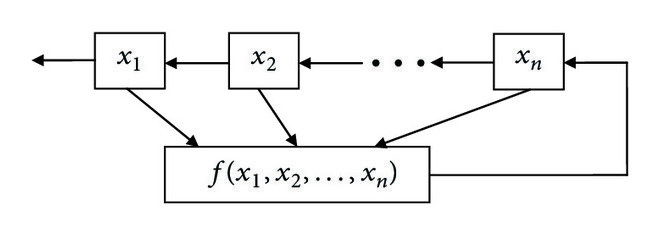

*Figure credits:* Wang et al. On Stability of Multi-Valued Nonlinear Feedback Shift Registers.

In [1]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from wbkit.prng import NFSR, Pool

C = BooleanCircuit(name="prng")

nfsr = NFSR(
    # f(x) = 1 ^ x0 ^ x2 ^ x1&x2&x3
    taps=[[], [0], [2], [1, 2, 3]],
    clocks_initial=10,
    clocks_per_step=2,
)

x = C.add_inputs(4, "x%d")

nfsr.set_state(x)

for i in range(5):
    rand = nfsr.step()
    C.add_output(rand)

C.in_place_remove_unused_nodes()

In [2]:
from binteger import Bin

for i in range(2**4):
    x = Bin(i, 4).tuple
    print(x, "->", C.evaluate(x))

(0, 0, 0, 0) -> [0, 1, 0, 0, 1]
(0, 0, 0, 1) -> [1, 0, 0, 1, 0]
(0, 0, 1, 0) -> [0, 1, 0, 0, 1]
(0, 0, 1, 1) -> [1, 0, 0, 1, 0]
(0, 1, 0, 0) -> [0, 0, 1, 0, 0]
(0, 1, 0, 1) -> [1, 1, 1, 0, 0]
(0, 1, 1, 0) -> [0, 0, 1, 0, 0]
(0, 1, 1, 1) -> [1, 1, 0, 0, 1]
(1, 0, 0, 0) -> [0, 1, 0, 0, 1]
(1, 0, 0, 1) -> [1, 0, 0, 1, 0]
(1, 0, 1, 0) -> [0, 0, 1, 1, 1]
(1, 0, 1, 1) -> [0, 1, 1, 1, 1]
(1, 1, 0, 0) -> [0, 0, 1, 0, 0]
(1, 1, 0, 1) -> [1, 1, 1, 1, 0]
(1, 1, 1, 0) -> [1, 0, 0, 1, 1]
(1, 1, 1, 1) -> [1, 1, 1, 1, 1]


In [3]:
C.digraph().view()

'Digraph.gv.pdf'

### Pooling NFSR outputs for efficiency

At the cost of sacrificing provably security guarantees, we can reuse NFSR outputs many times, in order to improve efficiency.

In [4]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from wbkit.prng import NFSR, Pool

C = BooleanCircuit(name="prng")

nfsr = NFSR(
    # f(x) = 1 ^ x0 ^ x2 ^ x1&x2&x3
    taps=[[], [0], [2], [1, 2, 3]],
    clocks_initial=10,
    clocks_per_step=2,
)
prng = Pool(prng=nfsr, n=5)

x = C.add_inputs(4, "x%d")
prng.set_state(x)

for i in range(10):
    rand = prng.step()
    C.add_output(rand)

C.in_place_remove_unused_nodes()

In [5]:
from binteger import Bin

for i in range(2**4):
    x = Bin(i, 4).tuple
    print(x, "->", C.evaluate(x))

(0, 0, 0, 0) -> [1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
(0, 0, 0, 1) -> [0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
(0, 0, 1, 0) -> [1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
(0, 0, 1, 1) -> [0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
(0, 1, 0, 0) -> [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
(0, 1, 0, 1) -> [0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
(0, 1, 1, 0) -> [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
(0, 1, 1, 1) -> [1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
(1, 0, 0, 0) -> [1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
(1, 0, 0, 1) -> [0, 0, 1, 0, 0, 1, 1, 0, 1, 1]
(1, 0, 1, 0) -> [1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
(1, 0, 1, 1) -> [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
(1, 1, 0, 0) -> [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
(1, 1, 0, 1) -> [0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
(1, 1, 1, 0) -> [1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
(1, 1, 1, 1) -> [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Applying countermeasures (masking, shuffling)

Setup AES Circuit:

In [6]:
from binteger import Bin
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from wbkit.ciphers.aes import BitAES

C = BooleanCircuit(name="AES")

key = b"abcdefghABCDEFGH"
plaintext = b"0123456789abcdef"

pt = C.add_inputs(128)
ct, k10 = BitAES(pt, Bin(key).tuple, rounds=10)
C.add_output(ct)

C.in_place_remove_unused_nodes()
C.print_stats()

ct = C.evaluate(Bin(plaintext).tuple)

AES(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  31273 nodes
   | XOR:19284 (61.66%), AND:6240 (19.95%), NOT:5621 (17.97%), INPUT:128 (0.41%)


Setup better PRNG:

In [7]:
nfsr = NFSR(
    taps=[[], [11], [50], [3, 107]],
    clocks_initial=100,
    clocks_per_step=1,
)
prng = Pool(prng=nfsr, n=256)

### Linear Masking [Ishai-Sahai-Wagner 2003]

*Statically:* Linear masking splits each intermediate computed value $s$ into $n$ **linear shares**:
$$s = x_1 \oplus x_2 \oplus \ldots \oplus x_n$$

*Dynamically:* Replace original operations with **gadgets** operating on **shares** of the inputs and computing **shares** of the output in a secure way. Requires **randomness** for encoding inputs / gadgets.

*Security:* against **correlation** of any $\le n-1$ shares/intermediates to the original sensitive value $s$.

In [8]:
from wbkit.masking import ISW

C_ISW = ISW(prng=prng, order=1).transform(C)
C_ISW.in_place_remove_unused_nodes()
C_ISW.print_stats()

assert ct == C_ISW.evaluate(Bin(plaintext).tuple)

AES_ISW(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  95392 nodes
   | XOR:64496 (67.61%), AND:24836 (26.04%), NOT:5932 (6.22%), INPUT:128 (0.13%)


### Non-linear Masking [Biryukov-Udovenko 2018]

*Statically:* Split each intermediate computed value $s$ into $3$ **(non)linear shares**:
$$s = x_1x_2 \oplus x_3$$

*Dynamically:* Similar to linear (computations using **gadgets**).

*Security:* against **linear algebraic** (**linear decoding**) attacks.

In [9]:
from wbkit.masking import MINQ

C_MINQ = MINQ(prng=prng).transform(C)
C_MINQ.in_place_remove_unused_nodes()
C_MINQ.print_stats()

assert ct == C_MINQ.evaluate(Bin(plaintext).tuple)

AES_MINQ(OptBooleanCircuit): 
   |   128 inputs,  128 outputs, 837645 nodes
   | XOR:577583 (68.95%), AND:253957 (30.32%), NOT:5977 (0.71%), INPUT:128 (0.02%)


### Combined Masking [Seker,Eisenbarth,Liśkiewicz 2021]

*Statically:* Split each intermediate computed value $s$ into **linear** and **non-linear shares**:

$$s = \tilde{x_1} \tilde{x_2} \oplus x_1 \oplus \ldots \oplus x_n$$

(more nonlinear shares are possible (provable construction for 2,3 shares))

*Dynamically:* Similar to linear (computations using **gadgets**).

*Security:* against **linear algebraic** (**linear decoding**) attacks.

In [10]:
from wbkit.masking import QuadLin

C_QL = QuadLin(prng=prng, n_linear=3).transform(C)
C_QL.in_place_remove_unused_nodes()
C_QL.print_stats()

assert ct == C_QL.evaluate(Bin(plaintext).tuple)

AES_QuadLin(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,1471640 nodes
   | XOR:1073933 (72.98%), AND:391602 (26.61%), NOT:5977 (0.41%), INPUT:128 (0.01%)


### Dummy shuffling [Biryukov-Udovenko 2021]

*Idea*: duplicate the circuit $C$ identically $n$ times (slots), choose **dynamically** at random the position of the right input, compute on random inputs in the other slots.

*Statically:* Each variable is shared into $n$ shares 

$$(x_1, \ldots, x_n), ~\text{where}~ x_i = s ~~\text{if}~i = f(\text{input})~~\text{and random otherwise}$$

*Dynamically:* Perform usual computations independently on each of the slots (+shuffle inputs and determine the right output).

*Security:* against the **linear algebraic** attack.

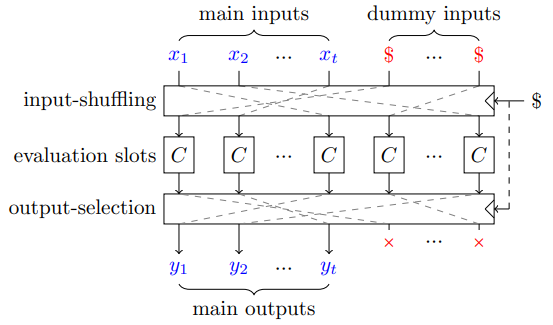

In [11]:
from wbkit.masking import DumShuf

C_DS = DumShuf(prng=prng, n_shares=2).transform(C)
C_DS.in_place_remove_unused_nodes()
C_DS.print_stats()

assert ct == C_DS.evaluate(Bin(plaintext).tuple)

AES_DumShuf(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  77729 nodes
   | XOR:52656 (67.74%), AND:13347 (17.17%), NOT:11598 (14.92%), INPUT:128 (0.16%)


## Serialization to file (internal binary format)

To do fast trace recording, we serialize the circuit into an internal binary format, into a file:

In [12]:
from wbkit.serialize import RawSerializer

RawSerializer().serialize_to_file(C, "circuits/aes10_clear.bin")

**Note**: the serializer does not support constants (only the NOT operation), so the call to
```py
C.in_place_remove_unused_nodes()
```
is necessary.

# Exercise

Generate circuits of the 2-round AES protected using the following countermeasure combinations and save them to respective files:

- `circuits/aes2_clear.bin` : unprotected AES
- `circuits/aes2_isw2.bin`  : linear masking (ISW) with 2 shares (order 1)
- `circuits/aes2_isw3.bin`  : linear masking (ISW) with 3 shares (order 2)
- `circuits/aes2_minq.bin`  : minimalist quadratic masking (~same as combined with 1 linear share)
- `circuits/aes2_quadlin2.bin` : combined quadratic masking (2 linear shares)
- `circuits/aes2_quadlin3.bin` : combined quadratic masking (3 linear shares)

Note: you can use the existing `prng` object.

---------------------------------
SOLUTION BELOW, WILL BE REMOVED

In [13]:
from binteger import Bin
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from wbkit.ciphers.aes import BitAES

C = BooleanCircuit(name="AES")

key = b"abcdefghABCDEFGH"
plaintext = b"0123456789abcdef"

pt = C.add_inputs(128)
ct, k10 = BitAES(pt, Bin(key).tuple, rounds=2)
C.add_output(ct)
C.in_place_remove_unused_nodes()

In [14]:
import gc
from wbkit.masking import QuadLin, ISW, MINQ, DumShuf

isw2 = ISW(prng=prng, order=1)
isw3 = ISW(prng=prng, order=2)
minq = MINQ(prng=prng)
quadlin1 = QuadLin(prng=prng, n_linear=1)
quadlin2 = QuadLin(prng=prng, n_linear=2)
quadlin3 = QuadLin(prng=prng, n_linear=3)
dumshuf2 = DumShuf(prng=prng, n_shares=2)
dumshuf3 = DumShuf(prng=prng, n_shares=3)

todo = {
    "circuits/aes2_clear.bin": [],
    "circuits/aes2_isw2.bin": [isw2],
    "circuits/aes2_isw3.bin": [isw3],
    "circuits/aes2_minq.bin": [minq],
    "circuits/aes2_quadlin1.bin": [quadlin1],
    "circuits/aes2_quadlin2.bin": [quadlin2],
    "circuits/aes2_quadlin3.bin": [quadlin3],
    "circuits/aes2_dumshuf2.bin": [dumshuf2],
    "circuits/aes2_dumshuf3.bin": [dumshuf3],
}
for name, trs in todo.items():
    print(name)
    Cnew = C
    for tr in trs:
        Cnew = tr.transform(Cnew)
        Cnew.in_place_remove_unused_nodes()
    Cnew.print_stats()
    
    RawSerializer().serialize_to_file(Cnew, name)
    print()
    gc.collect()

circuits/aes2_clear.bin
AES(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,   5825 nodes
   | XOR:3380 (58.03%), AND:1248 (21.42%), NOT:1069 (18.35%), INPUT:128 (2.20%)

circuits/aes2_isw2.bin
AES_ISW(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  19487 nodes
   | XOR:12720 (65.27%), AND:5252 (26.95%), NOT:1387 (7.12%), INPUT:128 (0.66%)

circuits/aes2_isw3.bin
AES_ISW(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  39056 nodes
   | XOR:26339 (67.44%), AND:11204 (28.69%), NOT:1385 (3.55%), INPUT:128 (0.33%)

circuits/aes2_minq.bin
AES_MINQ(OptBooleanCircuit): 
   |   128 inputs,  128 outputs, 162928 nodes
   | XOR:113795 (69.84%), AND:47580 (29.20%), NOT:1425 (0.87%), INPUT:128 (0.08%)

circuits/aes2_quadlin1.bin
AES_QuadLin(OptBooleanCircuit): 
   |   128 inputs,  128 outputs, 163520 nodes
   | XOR:114377 (69.95%), AND:47590 (29.10%), NOT:1425 (0.87%), INPUT:128 (0.08%)

circuits/aes2_quadlin2.bin
AES_QuadLin(OptBooleanCircuit): 
   |   128 inputs,  128 outputs, 2